In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras.layers import Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras

In [3]:
print(os.listdir("/gdrive/My Drive/DerinOgrenmeProje/lung_image_sets"))

['lung_squamous cell carcinoma', 'lung_adenocarcinoma', 'lung_benign tissue']


In [4]:
DATADIR = "/gdrive/My Drive/DerinOgrenmeProje/lung_image_sets"

CATEGORIES = ['lung_adenocarcinoma', 'lung_squamous cell carcinoma', 'lung_benign tissue']

IMG_SIZE = 100

In [5]:
all_data =[]

def create_all_data():
    for category in CATEGORIES:
        path=os.path.join(DATADIR, category)
        class_num=CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))
                new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
                all_data.append([new_array,class_num])
            except Exception as e:
                pass
create_all_data()

In [6]:
print("Toplam Görüntü Sayısı: ", len(all_data))

Toplam Görüntü Sayısı:  15000


In [7]:
X = []
y = []

for categories, label in all_data:
  X.append(categories)
  y.append(label)

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state =42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.10, random_state=42)

In [9]:
x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

x_val = np.array(x_val)
y_val = np.array(y_val)

In [10]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(9450, 100, 100, 3)
(4500, 100, 100, 3)
(1050, 100, 100, 3)
(9450,)
(4500,)
(1050,)


In [11]:
train_yCl = tf.keras.utils.to_categorical(y_train, num_classes=3)
test_yCl = tf.keras.utils.to_categorical(y_test, num_classes=3)
valid_yCl = tf.keras.utils.to_categorical(y_val, num_classes=3)

In [27]:
model = Sequential()

# Giriş katmanı (Flatten ile görüntüleri vektöre çevirme)
model.add(Flatten(input_shape=(IMG_SIZE, IMG_SIZE, 3)))


model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

model.add(BatchNormalization())

#Output Layer
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
callback_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.h5',
        monitor = 'val_accuracy', save_best_only=True, verbose=3
    ),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=3)
]

In [29]:
history = model.fit(x_train, train_yCl,
                    epochs=50,
                    validation_data=(x_val, valid_yCl),
                    callbacks = callback_list,
                    )

Epoch 1/50
290/296 [============================>.] - ETA: 0s - loss: 0.6546 - accuracy: 0.6673
Epoch 1: val_accuracy improved from -inf to 0.75810, saving model to model.h5
296/296 [==============================] - 5s 12ms/step - loss: 0.6526 - accuracy: 0.6685 - val_loss: 0.4742 - val_accuracy: 0.7581
Epoch 2/50
291/296 [============================>.] - ETA: 0s - loss: 0.5210 - accuracy: 0.7198
Epoch 2: val_accuracy did not improve from 0.75810
296/296 [==============================] - 3s 11ms/step - loss: 0.5202 - accuracy: 0.7196 - val_loss: 0.5293 - val_accuracy: 0.7076
Epoch 3/50
295/296 [============================>.] - ETA: 0s - loss: 0.4936 - accuracy: 0.7468
Epoch 3: val_accuracy did not improve from 0.75810
296/296 [==============================] - 3s 12ms/step - loss: 0.4938 - accuracy: 0.7467 - val_loss: 0.5548 - val_accuracy: 0.7343
Epoch 4/50
294/296 [============================>.] - ETA: 0s - loss: 0.4924 - accuracy: 0.7531
Epoch 4: val_accuracy did not improve fr

In [49]:
res_model = keras.models.load_model('/content/model.h5')

In [48]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(test_yCl, axis=1)

accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average="weighted")
recall = recall_score(y_test_classes, y_pred_classes, average="weighted")
f1_value = f1_score(y_test_classes, y_pred_classes, average="weighted")

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_value)

141/141 [==============================] - 1s 4ms/step
Accuracy: 0.7157777777777777
Precision: 0.7541668208960861
Recall: 0.7157777777777777
F1 Score: 0.6847170274375286


In [46]:
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 413 1090   21]
 [  79 1413    0]
 [  85    4 1395]]


In [32]:
class_report = classification_report(y_test_classes, y_pred_classes)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.27      0.39      1524
           1       0.56      0.95      0.71      1492
           2       0.99      0.94      0.96      1484

    accuracy                           0.72      4500
   macro avg       0.75      0.72      0.69      4500
weighted avg       0.75      0.72      0.68      4500



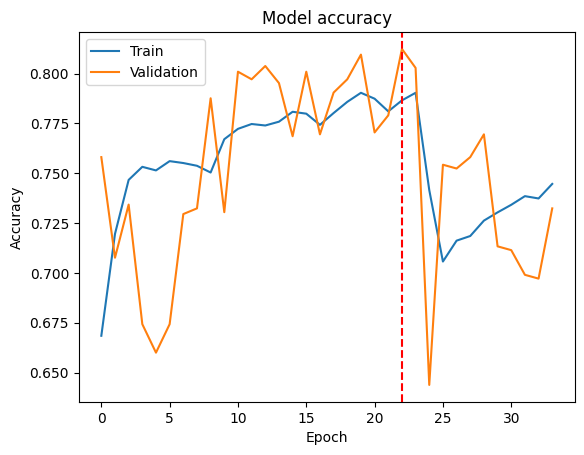

In [51]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


# Early stopping durumunda çizgi ekleme
if 'val_accuracy' in history.history and 'val_loss' in history.history:
    best_epoch = np.argmax(history.history['val_accuracy'])
    plt.axvline(x=best_epoch, color='r', linestyle='--', label='Early Stopping Checkpoint')

plt.show()

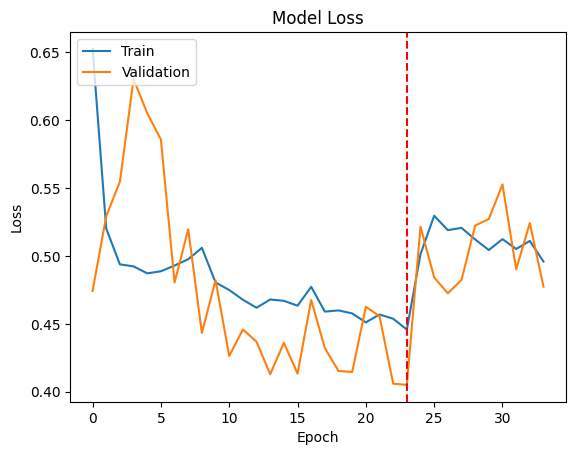

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Early stopping durumunda çizgi ekleme
if 'val_accuracy' in history.history and 'val_loss' in history.history:
    best_epoch = np.argmin(history.history['val_loss'])
    plt.axvline(x=best_epoch, color='r', linestyle='--', label='Early Stopping Checkpoint')

plt.show()

In [54]:
#model.h5'e göre Skorlar
y_pred = res_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(test_yCl, axis=1)

accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average="weighted")
recall = recall_score(y_test_classes, y_pred_classes, average="weighted")
f1_value = f1_score(y_test_classes, y_pred_classes, average="weighted")

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_value)

141/141 [==============================] - 1s 4ms/step
Accuracy: 0.786
Precision: 0.7938458795012469
Recall: 0.786
F1 Score: 0.7869923550445673
